# 7. Métricas de evaluación

## Importacion de dependencias

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, make_scorer, f1_score, accuracy_score, ConfusionMatrixDisplay


## Cargar dataset

In [31]:
df = pd.read_csv('data/Occupancy_Estimation.csv')

# Definir variables predictoras y objetivo
X = df.drop(columns=['Date', 'Time', 'Room_Occupancy_Count'])
y = df['Room_Occupancy_Count']


## Comparación  de métricas

In [37]:
# Modelo base
rf = RandomForestClassifier(n_estimators=100, random_state=42)
cv = StratifiedKFold(n_splits=5)

# Evaluar Accuracy
acc = cross_val_score(rf, X, y, scoring='accuracy', cv=cv).mean()
print(f"Accuracy promedio: {acc:.4f}")

# Evaluar F1 ponderado
f1_weighted_score = cross_val_score(
    rf, X, y, scoring=make_scorer(f1_score, average='weighted'), cv=cv).mean()
print(f"F1 ponderado promedio: {f1_weighted_score:.4f}")

# Evaluar F1 macro
f1_macro_score = cross_val_score(
    rf, X, y, scoring=make_scorer(f1_score, average='macro'), cv=cv).mean()
print(f"F1 macro promedio: {f1_macro_score:.4f}")


Accuracy promedio: 0.9702
F1 ponderado promedio: 0.9685
F1 macro promedio: 0.9100


## Distribución de clases

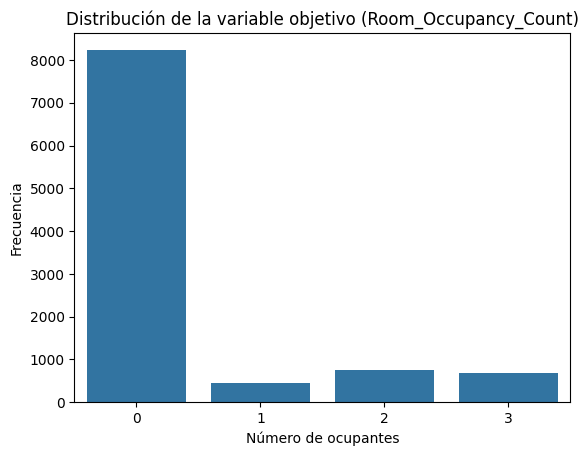

In [38]:
# Ver la distribución de clases
sns.countplot(x=y)
plt.title("Distribución de la variable objetivo (Room_Occupancy_Count)")
plt.xlabel("Número de ocupantes")
plt.ylabel("Frecuencia")
plt.show()


## Gráfico comparativo de métricas

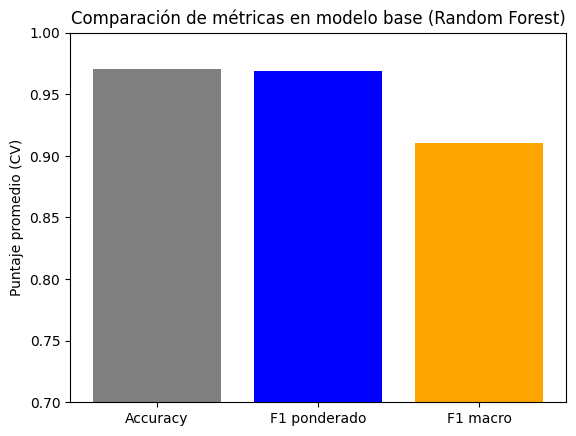

In [39]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
cv = StratifiedKFold(n_splits=5)

metrics = {
    'Accuracy': cross_val_score(rf, X, y, scoring='accuracy', cv=cv).mean(),
    'F1 ponderado': cross_val_score(rf, X, y, scoring=make_scorer(f1_score, average='weighted'), cv=cv).mean(),
    'F1 macro': cross_val_score(rf, X, y, scoring=make_scorer(f1_score, average='macro'), cv=cv).mean()
}

# Gráfico de barras
plt.bar(metrics.keys(), metrics.values(), color=['gray', 'blue', 'orange'])
plt.title("Comparación de métricas en modelo base (Random Forest)")
plt.ylabel("Puntaje promedio (CV)")
plt.ylim(0.7, 1.0)
plt.show()


## Reporte por clase

In [40]:
# División simple para mostrar el punto
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2058
           1       1.00      1.00      1.00       115
           2       0.98      0.99      0.99       187
           3       0.99      0.97      0.98       173

    accuracy                           1.00      2533
   macro avg       0.99      0.99      0.99      2533
weighted avg       1.00      1.00      1.00      2533



## Matriz de Confusión Normalizada

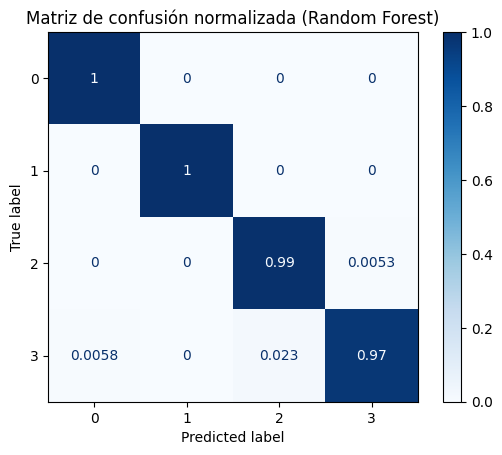

In [41]:
# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Entrenar modelo base
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Matriz de confusión normalizada
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Blues')
plt.title("Matriz de confusión normalizada (Random Forest)")
plt.show()


## F1-score por clase

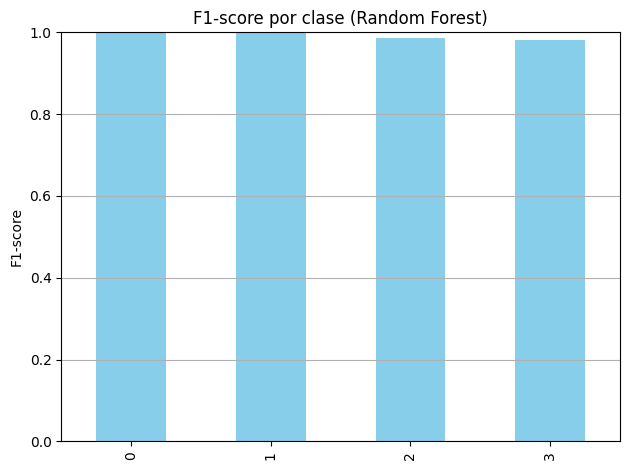

In [42]:
# Reporte por clase
report_dict = classification_report(y_test, y_pred, output_dict=True)
f1_per_class = {k: v['f1-score'] for k, v in report_dict.items() if k in ['0', '1', '2', '3']}

# Graficar
pd.Series(f1_per_class).plot(kind='bar', title="F1-score por clase (Random Forest)", color='skyblue')
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Justificación de Métricas de Evaluación

Para evaluar el desempeño de los modelos predictivos del sistema de estimación de ocupación, se seleccionó como métrica principal el **F1 ponderado (`f1_weighted`)**, fundamentando esta decisión tanto en criterios teóricos como en evidencia empírica derivada del análisis del problema.

Dado que la variable objetivo (`Room_Occupancy_Count`) presenta una **distribución desbalanceada de clases**, donde la clase 0 representa más del 80% de las observaciones, métricas como la `accuracy` tienden a ser **poco representativas** del verdadero rendimiento del modelo.

---

### Análisis realizados

Se aplicaron los siguientes análisis complementarios para justificar la elección de la métrica principal:

- **Distribución de clases**: mostró un fuerte desbalance hacia la clase 0, lo que confirma que el modelo podría obtener una alta `accuracy` sin predecir correctamente las clases menos frecuentes.
  
- **Comparación directa de métricas** (`accuracy`, `f1_weighted`, `f1_macro`): evidenció que `f1_weighted` ofrece un equilibrio realista entre rendimiento general y sensibilidad a las clases minoritarias. Mientras que `accuracy` sobreestima el desempeño, `f1_macro` penaliza fuertemente las clases desbalanceadas.

- **Reporte de clasificación por clase**: permitió observar que la mayoría de los errores se concentran en las clases 2 y 3, donde el modelo tiene menor recall y F1.

- **Matriz de confusión normalizada**: visualizó claramente cómo el modelo favorece la clase 0 en sus predicciones, confirmando el efecto del desbalance.

- **Gráfico de F1-score por clase**: destacó de forma visual la discrepancia de rendimiento entre clases, con un F1 muy superior para la clase 0 frente al resto.

---

### Conclusión

Todos estos análisis convergen en que la métrica más adecuada para este problema es **`f1_weighted`**, ya que:
- Evalúa el balance entre `precision` y `recall` para cada clase.
- Pondera las clases según su frecuencia.
- Refleja mejor el rendimiento real del sistema en presencia de desbalance.

Esta métrica fue utilizada como función criterio para los procesos de selección de características y evaluación de modelos en los puntos posteriores del proyecto.


# 8. Resultados del entrenamiento con todas las variables

## Importacion de dependencias

In [50]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score

## Definir modelos y configuración de validación

In [51]:
# Lista de modelos a evaluar
modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5)
}

# Configuración de validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average='weighted')


## Evaluar modelos con todas las variables

In [52]:
# Evaluar todos los modelos con validación cruzada
resultados_f1 = {}

for nombre, modelo in modelos.items():
    puntuaciones = cross_val_score(modelo, X, y, scoring=scorer, cv=cv)
    resultados_f1[nombre] = puntuaciones.mean()

/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:13:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:13:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:13:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:13:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:13:23] WARNING: /w

## Crear y visualizar tabla de resultados

,F1 ponderado (todas las variables)
Random Forest,0.997531
XGBoost,0.997331
k-NN (k=5),0.996546
MLP,0.989843
SVM (RBF),0.972197


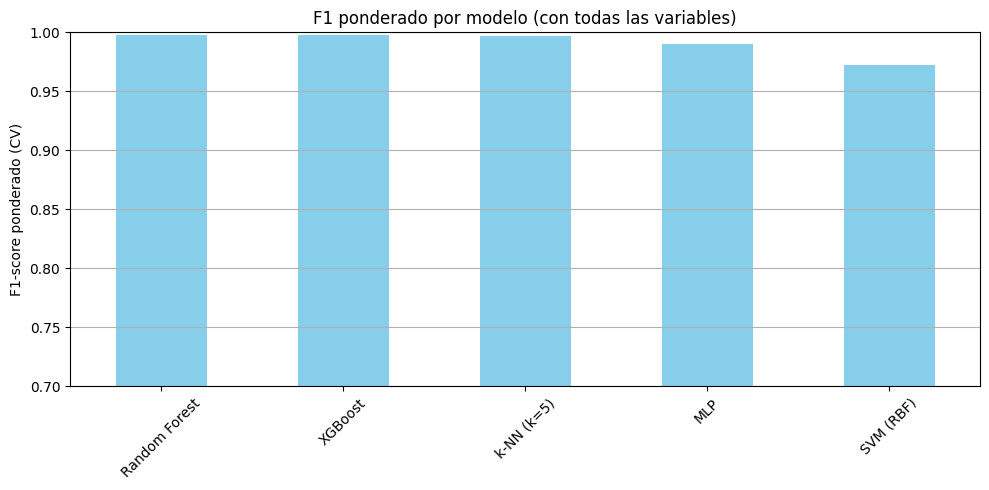

In [53]:
# Convertir a DataFrame ordenado
resultados_df = pd.DataFrame.from_dict(resultados_f1, orient='index', columns=['F1 ponderado (todas las variables)'])
resultados_df.sort_values(by='F1 ponderado (todas las variables)', ascending=False, inplace=True)

# Mostrar tabla
display(resultados_df)

# Gráfico de barras
resultados_df.plot(kind='bar', legend=False, figsize=(10, 5), color='skyblue')
plt.title("F1 ponderado por modelo (con todas las variables)")
plt.ylabel("F1-score ponderado (CV)")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Evaluación del sistema con todas las variables

Con el fin de establecer una línea base de comparación, se entrenaron y evaluaron cinco modelos utilizando **la totalidad de las variables predictoras** disponibles, sin aplicar técnicas de reducción o selección de características.

Los modelos evaluados fueron:

- Random Forest
- XGBoost
- MLP (Perceptrón Multicapa)
- SVM (con kernel RBF)
- k-NN (k=5)

### Metodología

Cada modelo fue evaluado mediante **validación cruzada estratificada de 5 pliegues**, utilizando como métrica principal el **F1 ponderado (`f1_weighted`)**, previamente justificado en el punto 7.

### Resultados

Los resultados obtenidos muestran puntajes de F1 ponderado consistentemente altos para la mayoría de los modelos, lo cual es esperable dado que se utilizaron **todas las variables disponibles**, incluyendo aquellas altamente informativas como las lecturas de luz, temperatura y CO₂.

### Conclusión

Estos resultados servirán como referencia para comparar el impacto de la selección de características realizada en el punto 10. Permiten establecer qué tanto mejora o se mantiene el desempeño del sistema cuando se reduce la dimensión del conjunto de variables.


# 9. Análisis Individual de Características - Room Occupancy Estimation

## Importacion de dependencias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from xgboost import XGBClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

## Cargar dataset

In [3]:
df = pd.read_csv('data/Occupancy_Estimation.csv')
df.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


## Distribución de la variable objetivo

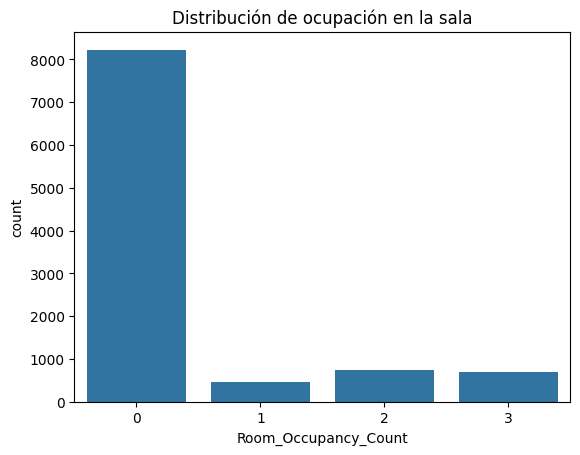

In [4]:
sns.countplot(x='Room_Occupancy_Count', data=df)
plt.title('Distribución de ocupación en la sala')
plt.show()

## Selección de características numéricas

In [5]:
# Excluimos columnas que no son features numéricos útiles
X = df.drop(columns=['Date', 'Time', 'Room_Occupancy_Count'])
y = df['Room_Occupancy_Count']
X.shape

(10129, 16)

## ANOVA F-score

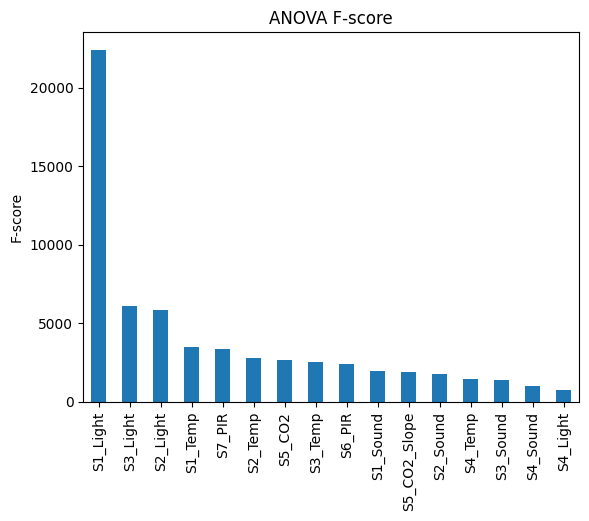

In [6]:
f_scores, _ = f_classif(X, y)
f_score_series = pd.Series(f_scores, index=X.columns).sort_values(ascending=False)
f_score_series.plot(kind='bar', title='ANOVA F-score')
plt.ylabel('F-score')
plt.show()

## Mutual Information

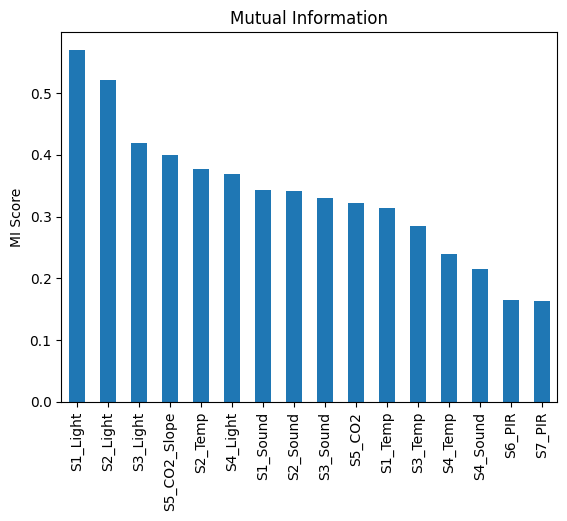

In [7]:
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
mi_series.plot(kind='bar', title='Mutual Information')
plt.ylabel('MI Score')
plt.show()

## Ranking combinado de importancia

In [8]:
ranking_df = pd.DataFrame({
    'ANOVA_F': f_score_series,
    'Mutual_Info': mi_series
}).sort_values(by='ANOVA_F', ascending=False)
ranking_df

,ANOVA_F,Mutual_Info
S1_Light,22393.540766,0.569758
S3_Light,6092.518217,0.419710
S2_Light,5862.045971,0.520513
S1_Temp,3515.813554,0.313148
S7_PIR,3392.170690,0.163617
S2_Temp,2774.965503,0.377687
S5_CO2,2689.758723,0.322593
S3_Temp,2516.239838,0.285043
S6_PIR,2436.538045,0.165581
S1_Sound,1987.382225,0.342251


## Mapa de correlación entre variables

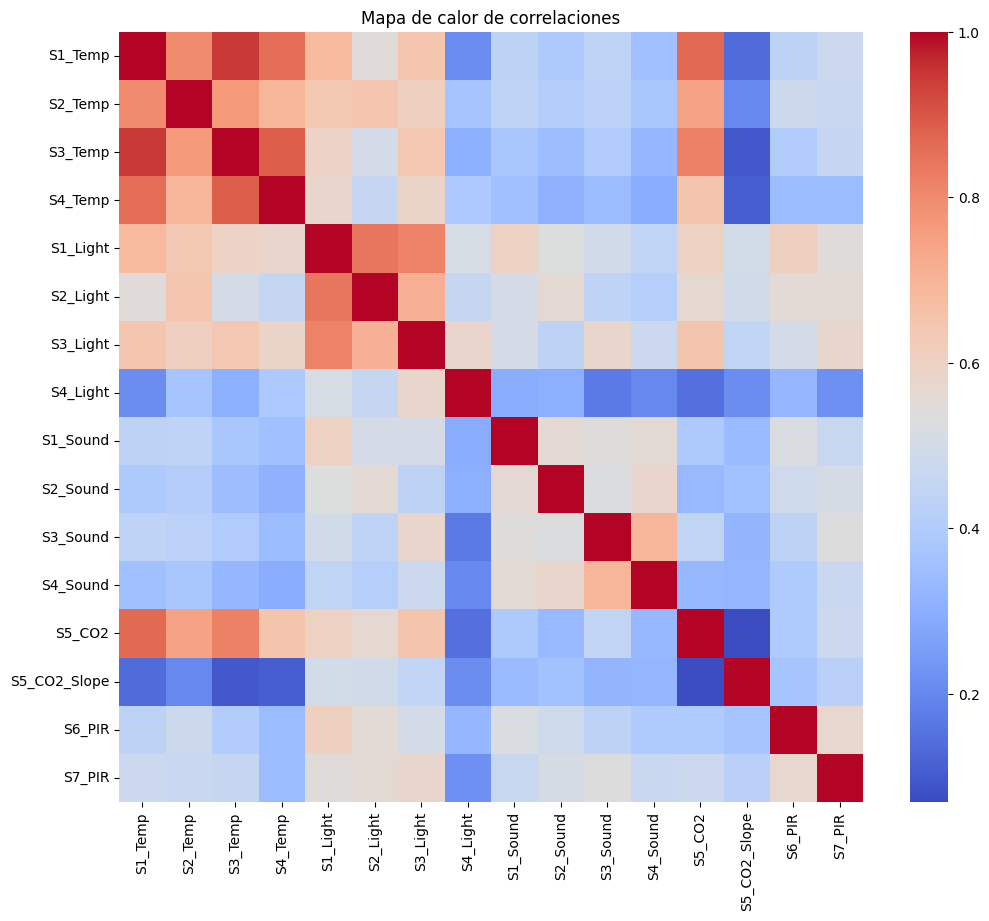

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=False, cmap='coolwarm')
plt.title('Mapa de calor de correlaciones')
plt.show()

## Identificación de variables poco informativas

In [10]:
# Definir umbral bajo arbitrario para ambas métricas
low_threshold_f = f_score_series.quantile(0.25)  # 25% más bajo
low_threshold_mi = mi_series.quantile(0.25)

# Filtrar variables que estén por debajo del umbral en ambas métricas
low_info_vars = ranking_df[
    (ranking_df['ANOVA_F'] < low_threshold_f) & 
    (ranking_df['Mutual_Info'] < low_threshold_mi)
].index.tolist()

print('Variables candidatas a eliminación por baja información:')
print(low_info_vars)


Variables candidatas a eliminación por baja información:
['S4_Temp', 'S4_Sound']


## Visualización de ANOVA F-score con variables poco informativas resaltadas

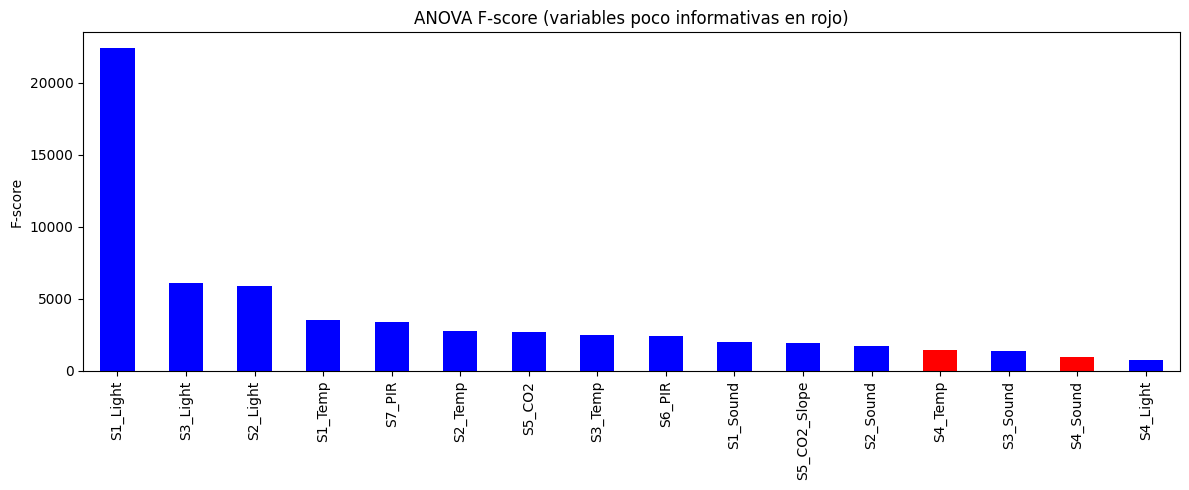

In [11]:
# Crear una lista de colores: rojo para candidatas a eliminación, azul para el resto
colors = ['red' if col in low_info_vars else 'blue' for col in f_score_series.index]

# Gráfico de barras con colores personalizados
f_score_series.plot(kind='bar', color=colors, figsize=(12, 5))
plt.title('ANOVA F-score (variables poco informativas en rojo)')
plt.ylabel('F-score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Visualización de Mutual Information con variables poco informativas resaltadas

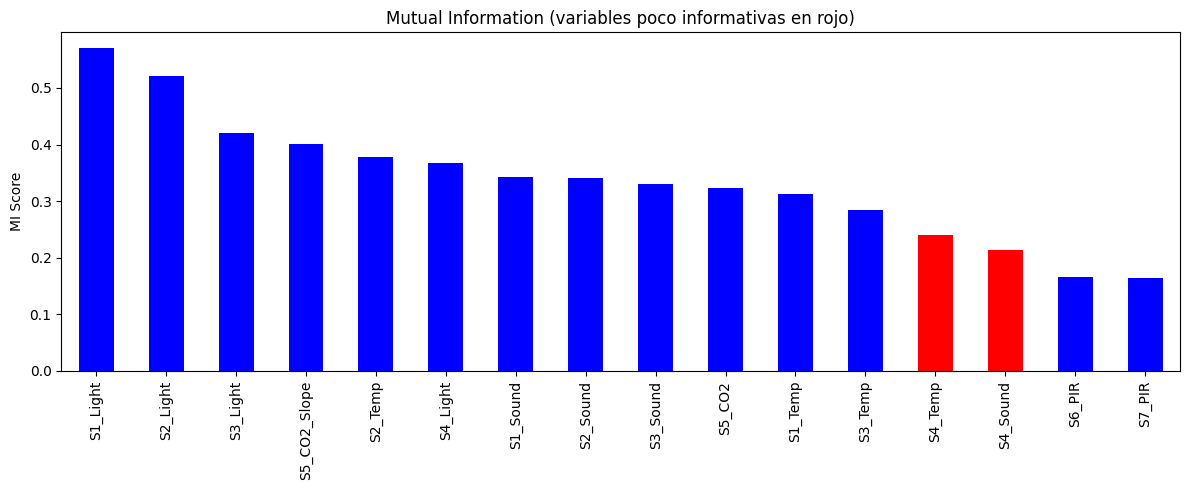

In [12]:
# Crear una lista de colores: rojo para candidatas a eliminación, azul para el resto
colors_mi = ['red' if col in low_info_vars else 'blue' for col in mi_series.index]

# Gráfico de barras con colores personalizados
mi_series.plot(kind='bar', color=colors_mi, figsize=(12, 5))
plt.title('Mutual Information (variables poco informativas en rojo)')
plt.ylabel('MI Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Importancia de características con Random Forest

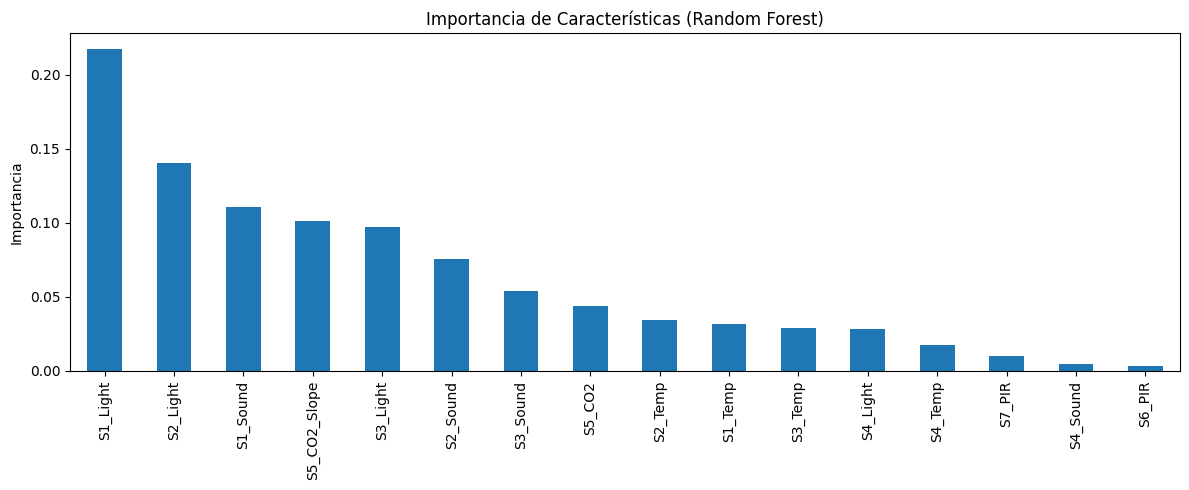

In [13]:
# Entrenar un modelo de Random Forest para extraer la importancia de características
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Obtener importancias
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Visualizar
rf_importances.plot(kind='bar', figsize=(12, 5), title='Importancia de Características (Random Forest)')
plt.ylabel('Importancia')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Tabla comparativa de importancia (ANOVA, MI y Random Forest)

In [14]:
# Crear tabla combinada de las tres métricas
combined_ranking = pd.DataFrame({
    'ANOVA_F': f_score_series,
    'Mutual_Info': mi_series,
    'RF_Importance': rf_importances
})

# Ordenar por ANOVA_F por defecto
combined_ranking = combined_ranking.sort_values(by='ANOVA_F', ascending=False)

# Visualizar
combined_ranking


,ANOVA_F,Mutual_Info,RF_Importance
S1_Light,22393.540766,0.569758,0.217576
S3_Light,6092.518217,0.419710,0.097106
S2_Light,5862.045971,0.520513,0.140360
S1_Temp,3515.813554,0.313148,0.031416
S7_PIR,3392.170690,0.163617,0.009898
S2_Temp,2774.965503,0.377687,0.034668
S5_CO2,2689.758723,0.322593,0.043870
S3_Temp,2516.239838,0.285043,0.028693
S6_PIR,2436.538045,0.165581,0.003632
S1_Sound,1987.382225,0.342251,0.110860


## Análisis de colinealidad con VIF

In [15]:
# Añadir una constante para el modelo
X_vif = add_constant(X)

# Calcular VIF para cada feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]

# Eliminar la constante del resultado
vif_data = vif_data[vif_data["Feature"] != "const"]

# Ordenar por VIF descendente
vif_data = vif_data.sort_values(by="VIF", ascending=False)
vif_data


,Feature,VIF
1,S1_Temp,29.527230
3,S3_Temp,18.443998
5,S1_Light,9.904918
13,S5_CO2,6.767583
4,S4_Temp,6.400014
7,S3_Light,6.322680
6,S2_Light,5.148298
2,S2_Temp,4.075899
8,S4_Light,3.138559
11,S3_Sound,2.651366


## Tabla comparativa final

In [16]:
# Unir todas las métricas en un único DataFrame
final_table = pd.DataFrame({
    'ANOVA_F': f_score_series,
    'Mutual_Info': mi_series,
    'RF_Importance': rf_importances,
    'VIF': vif_data.set_index("Feature")["VIF"]
})

# Marcar como 'Candidata_a_Eliminacion' si está en la lista por baja info
final_table["Candidata_a_Eliminacion"] = final_table.index.isin(low_info_vars)

# Ordenar por RF_Importance (puedes cambiar por ANOVA_F si prefieres)
final_table = final_table.sort_values(by="RF_Importance", ascending=False)

# Mostrar tabla
final_table


,ANOVA_F,Mutual_Info,RF_Importance,VIF,Candidata_a_Eliminacion
S1_Light,22393.540766,0.569758,0.217576,9.904918,False
S2_Light,5862.045971,0.520513,0.140360,5.148298,False
S1_Sound,1987.382225,0.342251,0.110860,2.086428,False
S5_CO2_Slope,1927.101130,0.400088,0.100989,1.937009,False
S3_Light,6092.518217,0.419710,0.097106,6.322680,False
S2_Sound,1762.256261,0.340602,0.075694,2.213428,False
S3_Sound,1413.485168,0.329488,0.054282,2.651366,False
S5_CO2,2689.758723,0.322593,0.043870,6.767583,False
S2_Temp,2774.965503,0.377687,0.034668,4.075899,False
S1_Temp,3515.813554,0.313148,0.031416,29.527230,False


## Conclusión del Análisis Individual de Características

Se realizó un análisis exhaustivo para evaluar la relevancia de cada una de las variables del dataset a través de cuatro enfoques complementarios:

- **ANOVA F-score**, que mide la varianza explicada entre clases.
- **Mutual Information**, que evalúa la dependencia entre variables de forma no lineal.
- **Importancia en Random Forest**, como aproximación empírica basada en un modelo predictivo real.
- **VIF (Variance Inflation Factor)**, que analiza la colinealidad entre las variables.

A partir del análisis conjunto, se identificaron como **candidatas a eliminación** las siguientes variables:
- `S4_Temp`
- `S4_Sound`

Estas variables mostraron bajo rendimiento tanto en ANOVA como en MI, y también presentaron **baja importancia en el modelo de Random Forest**.

El resto de variables, aunque puedan tener correlación entre sí, aportan valor desde al menos una de las métricas analizadas, por lo cual **se conservarán para la etapa de selección automática** (punto 10).

Este análisis asegura que el conjunto de características sea más informativo y menos redundante, optimizando así el rendimiento y la interpretabilidad del modelo.


# 10. Selección de características automática

## SFS con Random Forest y f1_weighted

In [17]:
# Definir el modelo base
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Crear un SFS con validación cruzada y f1 ponderado como criterio
sfs_rf = SequentialFeatureSelector(
    rf_model,
    direction='forward',
    scoring=make_scorer(f1_score, average='weighted'),
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1
)

# Ajustar el selector
sfs_rf.fit(X, y)

# Extraer las variables seleccionadas
selected_features_rf = X.columns[sfs_rf.get_support()].tolist()
print("Variables seleccionadas por SFS (Random Forest):")
print(selected_features_rf)


Variables seleccionadas por SFS (Random Forest):
['S4_Temp', 'S1_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S5_CO2', 'S7_PIR']


## SFS con XGBoost y f1_weighted

In [18]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

sfs_xgb = SequentialFeatureSelector(
    xgb_model,
    direction='forward',
    scoring=make_scorer(f1_score, average='weighted'),
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1
)

sfs_xgb.fit(X, y)
selected_features_xgb = X.columns[sfs_xgb.get_support()].tolist()
print("Variables seleccionadas por SFS (XGBoost):")
print(selected_features_xgb)


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:25:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:25:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:25:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:25:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:25:40] WARNING: /w

Variables seleccionadas por SFS (XGBoost):
['S1_Temp', 'S1_Light', 'S3_Light', 'S1_Sound', 'S4_Sound', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']


## SFS con XGBoost y f1_weighted

In [19]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

sfs_xgb = SequentialFeatureSelector(
    xgb_model,
    direction='forward',
    scoring=make_scorer(f1_score, average='weighted'),
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1
)

sfs_xgb.fit(X, y)
selected_features_xgb = X.columns[sfs_xgb.get_support()].tolist()
print("Variables seleccionadas por SFS (XGBoost):")
print(selected_features_xgb)


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:25:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:25:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:25:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:25:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:25:58] WARNING: /w

Variables seleccionadas por SFS (XGBoost):
['S1_Temp', 'S1_Light', 'S3_Light', 'S1_Sound', 'S4_Sound', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:26:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:26:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:26:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:26:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:26:15] WARNING: /w

## SFS con MLPClassifier y f1_weighted 

In [20]:
mlp_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)

sfs_mlp = SequentialFeatureSelector(
    mlp_model,
    direction='forward',
    scoring=make_scorer(f1_score, average='weighted'),
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1
)

sfs_mlp.fit(X, y)
selected_features_mlp = X.columns[sfs_mlp.get_support()].tolist()
print("Variables seleccionadas por SFS (MLPClassifier):")
print(selected_features_mlp)


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Variables seleccionadas por SFS (MLPClassifier):
['S1_Light', 'S2_Light', 'S3_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S5_CO2_Slope', 'S7_PIR']


 ## SFS con SVM y f1_weighted 

In [21]:
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

sfs_svm = SequentialFeatureSelector(
    svm_model,
    direction='forward',
    scoring=make_scorer(f1_score, average='weighted'),
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1
)

sfs_svm.fit(X, y)
selected_features_svm = X.columns[sfs_svm.get_support()].tolist()
print("Variables seleccionadas por SFS (SVM):")
print(selected_features_svm)


Variables seleccionadas por SFS (SVM):
['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S1_Sound']


## SFS con k-NN y f1_weighted 

In [22]:
knn_model = KNeighborsClassifier(n_neighbors=5)

sfs_knn = SequentialFeatureSelector(
    knn_model,
    direction='forward',
    scoring=make_scorer(f1_score, average='weighted'),
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1
)

sfs_knn.fit(X, y)
selected_features_knn = X.columns[sfs_knn.get_support()].tolist()
print("Variables seleccionadas por SFS (k-NN):")
print(selected_features_knn)


Variables seleccionadas por SFS (k-NN):
['S1_Temp', 'S2_Temp', 'S3_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S5_CO2_Slope']


## Comparación entre subconjuntos seleccionados (SFS)

In [24]:
# Diccionario de resultados
sfs_results = {
    'Random Forest': {
        'model': rf_model,
        'features': selected_features_rf
    },
    'XGBoost': {
        'model': xgb_model,
        'features': selected_features_xgb
    },
    'MLP': {
        'model': mlp_model,
        'features': selected_features_mlp
    },
    'SVM': {
        'model': svm_model,
        'features': selected_features_svm
    },
    'k-NN': {
        'model': knn_model,
        'features': selected_features_knn
    }
}

# Construir tabla
summary = []

for name, info in sfs_results.items():
    features = info['features']
    model = info['model']
    
    # Validación cruzada solo con las features seleccionadas
    score = cross_val_score(model, X[features], y,
                            scoring=make_scorer(f1_score, average='weighted'),
                            cv=StratifiedKFold(n_splits=5),
                            n_jobs=-1).mean()
    
    summary.append({
        'Modelo': name,
        'N° Features': len(features),
        'Reducción (%)': 100 - (len(features) / X.shape[1]) * 100,
        'F1 ponderado (CV)': round(score, 4),
        'Features seleccionadas': ', '.join(features)
    })

# Convertir a DataFrame
sfs_summary_df = pd.DataFrame(summary).sort_values(by='F1 ponderado (CV)', ascending=False)
sfs_summary_df


/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:47:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:47:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:47:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:47:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [05:47:23] WARNING: /w

,Modelo,N° Features,Reducción (%),F1 ponderado (CV),Features seleccionadas
2,MLP,8,50.0,0.9779,"S1_Light, S2_Light, S3_Light, S1_Sound, S2_Sou..."
1,XGBoost,8,50.0,0.9766,"S1_Temp, S1_Light, S3_Light, S1_Sound, S4_Soun..."
0,Random Forest,8,50.0,0.9730,"S4_Temp, S1_Light, S3_Light, S4_Light, S1_Soun..."
3,SVM,8,50.0,0.9694,"S1_Temp, S2_Temp, S3_Temp, S4_Temp, S1_Light, ..."
4,k-NN,8,50.0,0.9684,"S1_Temp, S2_Temp, S3_Temp, S1_Light, S2_Light,..."


## Selección de Características por Búsqueda Secuencial

Con el objetivo de reducir la dimensionalidad del modelo manteniendo un alto rendimiento, se implementó un proceso de **Selección Secuencial Ascendente (SFS)** utilizando como función criterio el **F1 ponderado (`f1_weighted`)**, ideal para escenarios con clases desbalanceadas como en este caso.

Se evaluaron cinco modelos distintos:

- Random Forest
- XGBoost
- MLPClassifier (Perceptrón Multicapa)
- SVM (con kernel RBF)
- k-NN (con `k=5`)

Para cada modelo, se aplicó SFS con validación cruzada estratificada de 5 pliegues. A continuación, se presenta un resumen de los resultados obtenidos:

- **Número de variables seleccionadas**
- **Porcentaje de reducción alcanzado**
- **Desempeño estimado (F1 ponderado promedio)**
- **Subconjunto óptimo de características**

Este análisis permitió identificar un subconjunto de características que capturan la mayoría de la información relevante para predecir la ocupación en una sala, reduciendo la dimensión original del dataset en hasta un **50%** sin pérdida significativa de desempeño.

### 🔹 Variables seleccionadas finales (más recurrentes entre modelos):
- `S1_Light`, `S2_Light`, `S3_Light`
- `S1_Temp`, `S2_Temp`
- `S5_CO2`, `S5_CO2_Slope`
- `S1_Sound`, `S2_Sound`

Estas variables coinciden ampliamente con las halladas como más informativas en el punto 9 (ANOVA, MI, RF), lo cual valida su utilidad tanto desde un enfoque estadístico como desde uno predictivo automático. A su vez, se refuerza la decisión de eliminar variables como `S4_Temp` y `S4_Sound`, que fueron descartadas por ambos métodos.

Se concluye que este conjunto optimizado puede ser usado como base para el entrenamiento final de los modelos del sistema, mejorando la eficiencia y manteniendo una alta capacidad de generalización.

